## Run model and collect predictions on BABILong

In [1]:
import os
os.chdir('..')
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import datasets
from tqdm.auto import tqdm
import pandas as pd
import json

from pathlib import Path

from babilong.prompts import DEFAULT_PROMPTS, DEFAULT_TEMPLATE, get_formatted_input
from babilong.babilong_utils import compare_answers

In [ ]:
torch.cuda.device_count()

In [3]:
results_folder = './babilong_evals'
model_name = 'CohereForAI/c4ai-command-r-v01'
dtype = torch.bfloat16
device_map = 'auto'

In [4]:
# uncomment to run on 32k, depending on your hardware setup
# bnb_config = BitsAndBytesConfig(load_in_8bit=True, llm_int8_enable_fp32_cpu_offload=True)
# device_map = {'model.embed_tokens': 0, 'lm_head': 'cpu',
#               'model.layers.0': 1, 'model.layers.1': 1, 'model.layers.2': 1, 'model.layers.3': 1, 'model.layers.4': 1, 'model.layers.5': 1,
#               'model.layers.6': 2, 'model.layers.7': 2, 'model.layers.8': 2, 'model.layers.9': 2, 'model.layers.10': 2, 'model.layers.11': 2,
#               'model.layers.12': 3, 'model.layers.13': 3, 'model.layers.14': 3, 'model.layers.15': 3, 'model.layers.16': 3, 'model.layers.17': 3,
#               'model.layers.18': 4, 'model.layers.19': 4, 'model.layers.20': 4, 'model.layers.21': 4, 'model.layers.22': 4, 'model.layers.23': 4,
#               'model.layers.24': 5, 'model.layers.25': 5, 'model.layers.26': 5, 'model.layers.27': 5, 'model.layers.28': 5, 'model.layers.29': 5,
#               'model.layers.30': 6, 'model.layers.31': 6, 'model.layers.32': 6, 'model.layers.33': 6, 'model.layers.34': 6,
#               'model.layers.35': 7, 'model.layers.36': 7, 'model.layers.37': 7, 'model.layers.38': 7, 'model.layers.39': 7,
#               'model.norm': 7}

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             device_map=device_map, dtype=dtype,
                                             attn_implementation='flash_attention_2')
# for 32k seq length
# model = AutoModelForCausalLM.from_pretrained(model_name, device_map=device_map,
#                                              quantization_config=bnb_config)
model = model.eval()

In [6]:
generate_kwargs = {
    'num_beams': 1,
    'do_sample': False,
    'temperature': None,
    'top_p': None,
    'top_k': None,
}

define prompt template

In [7]:
# following recommedation from https://huggingface.co/CohereForAI/c4ai-command-r-v01
# we use tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt")
# messages = [{"role": "user", "content": DEFAULT_TEMPLATE}]

In [8]:
DEFAULT_TEMPLATE

'{instruction}\n\n{examples}\n\n{post_prompt}\n\n<context>\n{context}\n</context>\n\nQuestion: {question}'

In [9]:
tasks = ['qa1', 'qa2', 'qa3', 'qa4', 'qa5'] #,['qa1', 'qa2', 'qa6', 'qa7', 'qa8', 'qa9', 'qa10']
split_names = ['0k', '1k', '2k', '4k', '8k', '16k'] #['32k'] # ['1k', '2k', '4k', '8k', '16k', '32k', '64k', '128k']

In [ ]:
# for each task
for task in tqdm(tasks, desc='tasks'):
    prompt_cfg = {
        'instruction': DEFAULT_PROMPTS[task]['instruction'],
        'examples': DEFAULT_PROMPTS[task]['examples'],
        'post_prompt': DEFAULT_PROMPTS[task]['post_prompt'],
        'template': DEFAULT_TEMPLATE,
    }
    prompt_name = [f'{k}_no' if len(prompt_cfg[k]) == 0 else f'{k}_yes' for k in prompt_cfg if k != 'template']
    prompt_name = '_'.join(prompt_name)
    
    # for each task length
    for split_name in tqdm(split_names, desc='lengths'):
        data = datasets.load_dataset("booydar/babilong", split_name)
        task_data = data[task].select(range(100))

        outfile = Path(f'{results_folder}/{model_name}/{task}_{split_name}_{prompt_name}.csv')
        outfile.parent.mkdir(parents=True, exist_ok=True)
        cfg_file = f'./{results_folder}/{model_name}/{task}_{split_name}_{prompt_name}.json'
        json.dump({'prompt': prompt_cfg, 'generate_kwargs': generate_kwargs}, open(cfg_file, 'w'), indent=4)

        df = pd.DataFrame({'target': [], 'output': []})

        for sample in task_data:
            target = sample['target']
            context = sample['input']
            question = sample['question']

            input_text = get_formatted_input(context, question, prompt_cfg['examples'],
                                             prompt_cfg['instruction'], prompt_cfg['post_prompt'],
                                             template=DEFAULT_TEMPLATE)

            input_text = [{"role": "user", "content": input_text}]

            model_inputs = tokenizer.apply_chat_template(input_text, tokenize=True, add_generation_prompt=True,
                                                         return_tensors="pt").to(model.device)
            sample_length = model_inputs.shape[1]
            with torch.no_grad():
                output = model.generate(model_inputs, max_new_tokens=15, **generate_kwargs)
            output = output[0][sample_length:]
            output = tokenizer.decode(output, skip_special_tokens=True).strip()

            df.loc[len(df)] = [target, output]
            df.to_csv(outfile)

## Evaluate results

In [2]:
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap

import pandas as pd
import numpy as np

# import os
# os.chdir('..')
from babilong.metrics import compare_answers, TASK_LABELS

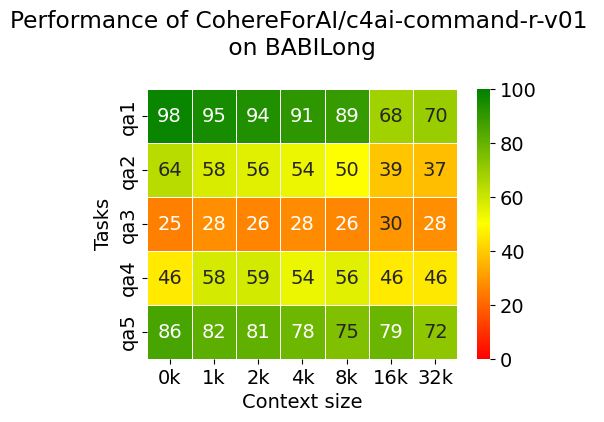

In [3]:
results_folder = './babilong_evals'
model_name = 'CohereForAI/c4ai-command-r-v01'
prompt_name = 'instruction_yes_examples_yes_post_prompt_yes'

tasks = ['qa1', 'qa2', 'qa3', 'qa4', 'qa5']#, 'qa6', 'qa7', 'qa8', 'qa9', 'qa10']
lengths = ['0k', '1k', '2k', '4k', '8k', '16k', '32k']

accuracy = np.zeros((len(tasks), len(lengths)))
for j, task in enumerate(tasks):
    for i, ctx_length in enumerate(lengths):
        fname = f'./{results_folder}/{model_name}/{task}_{ctx_length}_{prompt_name}.csv'
        if not os.path.isfile(fname):
            print(f'No such file: {fname}')
            continue
        
        df = pd.read_csv(fname)
        
        if df['output'].dtype != object:
            df['output'] = df['output'].astype(str)
        df['output'] = df['output'].fillna('')


        df['correct'] = df.apply(lambda row: compare_answers(row['target'], row['output'],
                                                             row['question'], TASK_LABELS[task]
                                                             ), axis=1)
        score = df['correct'].sum()
        accuracy[j, i] = 100 * score / len(df) if len(df) > 0 else 0

# Set large font sizes for better visibility in the PDF
matplotlib.rc('font', size=14)

# Create a colormap for the heatmap
cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)

# Create the heatmap
fig, ax = plt.subplots(figsize=(5, 3.5))  # Adjust the size as necessary
sns.heatmap(accuracy, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
            linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax)
ax.set_title(f'Performance of {model_name} \n on BABILong \n')
ax.set_xlabel('Context size')
ax.set_ylabel('Tasks')

# Save the figure to a PDF
# plt.savefig('all_tasks_performance.pdf', bbox_inches='tight')
plt.show()